In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d

from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [17]:
categories = [
    "CatchShoot",
    "Drives",
    "ElbowTouch",
    "PaintTouch",
    "Passing",
    "PostTouch",
    "PullUpShot",
]

In [20]:
regular_data = {}
playoff_data = {}

In [21]:
for category in categories:
    regular_df = LeagueDashPtStats(season='2020-21', per_mode_simple='PerGame', pt_measure_type=category, season_type_all_star='Regular Season', player_or_team='Team').get_data_frames()[0]
    time.sleep(0.3)
    playoff_df = LeagueDashPtStats(season='2020-21', per_mode_simple='PerGame', pt_measure_type=category, season_type_all_star='Playoffs', player_or_team='Team').get_data_frames()[0]
    regular_data[category] = regular_df
    playoff_data[category] = playoff_df

In [22]:
merged_data = {}


In [23]:
for key in regular_data:
    regular_df = regular_data[key]
    playoff_df = playoff_data[key]
    merged_df = pd.merge(left=regular_df, right=playoff_df, on=('TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME'), suffixes=('_REGULAR', '_PLAYOFF'))
    merged_data[key] = merged_df

In [25]:
target_keys = {
    "CatchShoot": 'CATCH_SHOOT_FGA',
    "PullUpShot": 'PULL_UP_FGA',
    "Drives": 'DRIVES',
    "Passing": 'PASSES_MADE',
    "ElbowTouch": 'ELBOW_TOUCHES',
    "PaintTouch": 'PAINT_TOUCHES',
    "PostTouch": 'POST_TOUCHES',
}

In [47]:
for key in target_keys:
    cur_df = merged_data[key]
    cur_df.loc[:, 'DIFF'] = cur_df[f"{target_keys[key]}_PLAYOFF"] - cur_df[f"{target_keys[key]}_REGULAR"]

In [48]:
cs_key = "CatchShoot"
column_key = target_keys[cs_key]

df = merged_data[cs_key]

In [31]:
plt.style.use('fivethirtyeight')

In [52]:
for key in target_keys:
    cur_df = merged_data[key]
    print(key, f"{cur_df.DIFF.mean():.2f}")

CatchShoot -1.88
PullUpShot 2.46
Drives 1.21
Passing -17.91
ElbowTouch -1.64
PaintTouch -1.14
PostTouch -1.26


[Text(0, 0, 'ATL'),
 Text(1, 0, 'BOS'),
 Text(2, 0, 'BKN'),
 Text(3, 0, 'DAL'),
 Text(4, 0, 'DEN'),
 Text(5, 0, 'LAC'),
 Text(6, 0, 'LAL'),
 Text(7, 0, 'MEM'),
 Text(8, 0, 'MIA'),
 Text(9, 0, 'MIL'),
 Text(10, 0, 'NYK'),
 Text(11, 0, 'PHI'),
 Text(12, 0, 'PHX'),
 Text(13, 0, 'POR'),
 Text(14, 0, 'UTA'),
 Text(15, 0, 'WAS')]

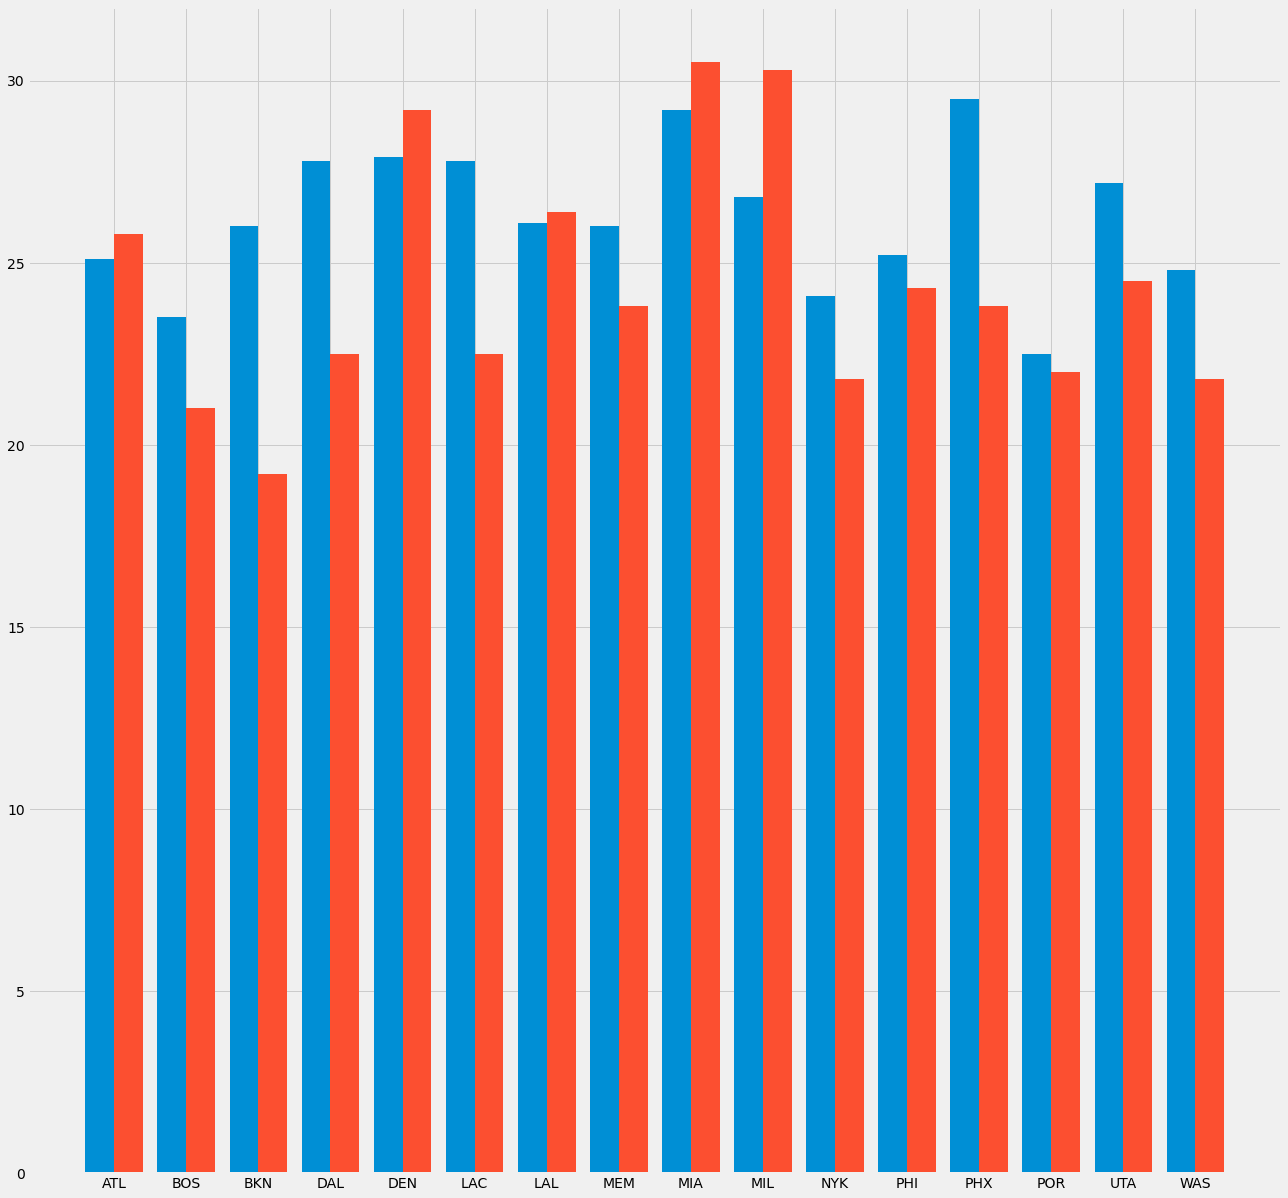

In [46]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.bar(x=[i-0.2 for i in range(len(df))], height=df[f"{column_key}_REGULAR"], width=0.4)
ax.bar(x=[i+0.2 for i in range(len(df))], height=df[f"{column_key}_PLAYOFF"], width=0.4)
ax.set_xticks([i for i in range(len(df))])
ax.set_xticklabels(df.TEAM_ABBREVIATION.tolist())